In [1]:
# Importing Data 
# Visualization and comments
# Feature Engineering -- Encoding catorigical column ,genrating new features and Feature Selection 
# Modelling
# Ensambling 


In [2]:

import pandas as pd 
import numpy as np 

## for Plottng and Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_profiling
from autoviz.AutoViz_Class import AutoViz_Class
import graphviz  # to visualse the decesion tree
from yellowbrick.contrib.classifier import DecisionViz
from mlxtend.plotting import plot_decision_regions

## To apply NN
from keras import  models
from keras.layers import Dense

# For encoding  categorical data
import category_encoders as ce


## scikit Library for models and Feature Engineering
from sklearn.model_selection import train_test_split
# models
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from  sklearn.preprocessing import StandardScaler 
from sklearn.feature_selection import SelectFromModel




Imported AutoViz_Class version: 0.0.68. Call using: 
    from autoviz.AutoViz_Class import AutoViz_Class
    AV = AutoViz_Class()
    AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=0,
                            lowess=False,chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30)
            
To remove previous versions, perform 'pip uninstall autoviz'


In [3]:
data=pd.read_csv("train.csv")
test_data=pd.read_csv("test.csv")
X_train, X_valid, y_train, y_valid = train_test_split( data.drop(columns="Survived"), data.Survived, test_size=0.1, random_state=42)
print("This is how our data looks like")
X_train.head()
# SibSp is the number of Siblings/Spouses on board
# Parch is the number of parents/children on board
# Pclass is the 1=1st , 2nd=2 and 3rd=3

This is how our data looks like


PassengerId  Pclass                                             Name  \
165          166       3  Goldsmith, Master. Frank John William "Frankie"   
541          542       3             Andersson, Miss. Ingeborg Constanzia   
625          626       1                            Sutton, Mr. Frederick   
388          389       3                             Sadlier, Mr. Matthew   
76            77       3                                Staneff, Mr. Ivan   

        Sex   Age  SibSp  Parch  Ticket     Fare Cabin Embarked  
165    male   9.0      0      2  363291  20.5250   NaN        S  
541  female   9.0      4      2  347082  31.2750   NaN        S  
625    male  61.0      0      0   36963  32.3208   D50        S  
388    male   NaN      0      0  367655   7.7292   NaN        Q  
76     male   NaN      0      0  349208   7.8958   NaN        S

### Data Visualization

In [4]:
report = pandas_profiling.ProfileReport(X_train)
display(report)

Shape of your Data Set: (891, 12)
Classifying variables in data set...
    12 Predictors classified...
        This does not include the Target column(s)
    4 variables removed since they were ID or low-information variables
Number of All Scatter Plots = 3
Time to run AutoViz (in seconds) = 5.751


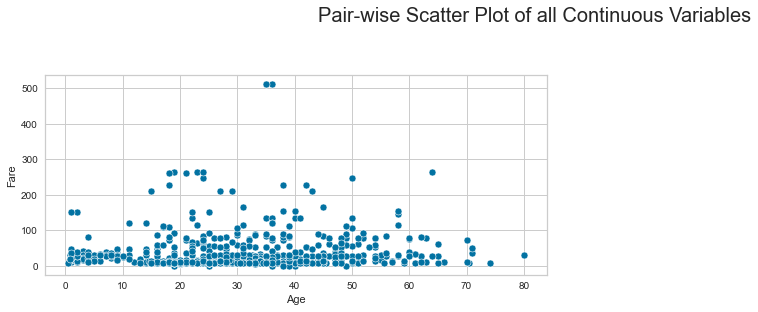

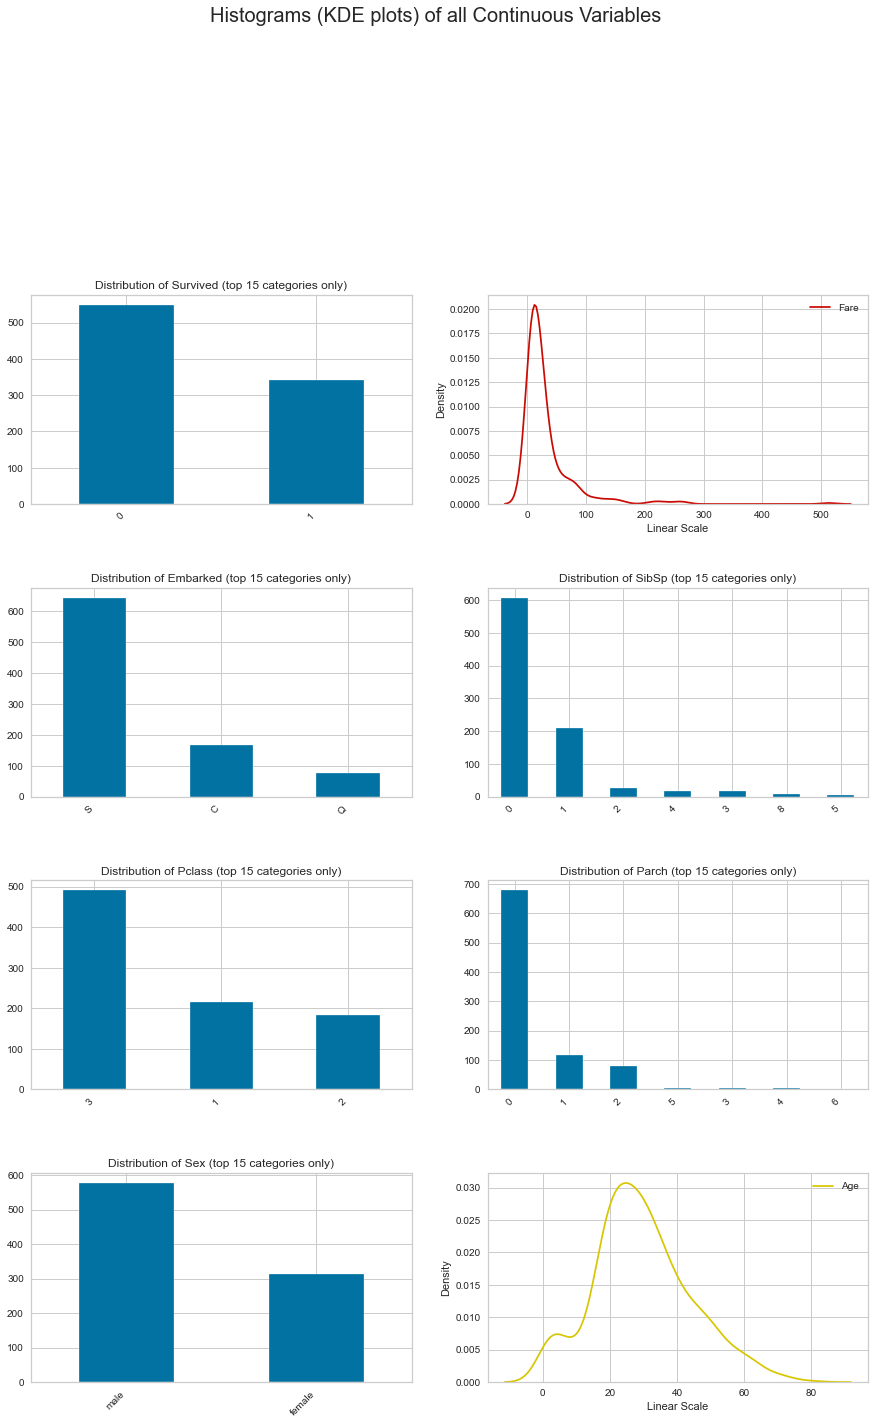

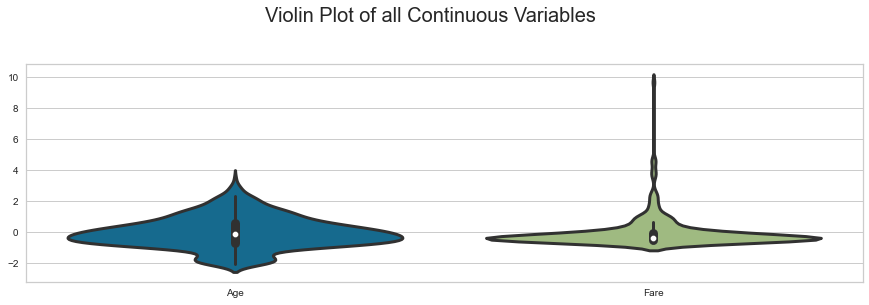

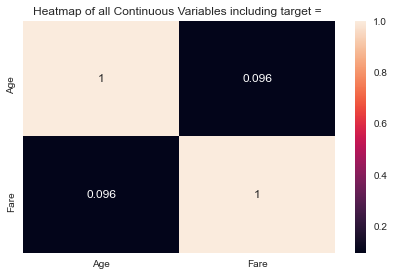

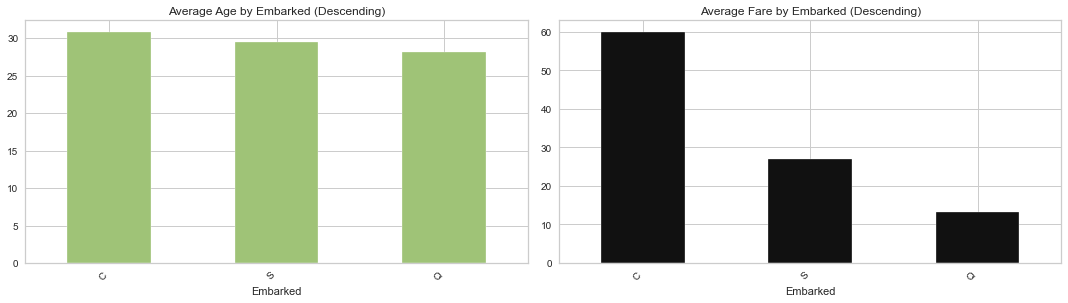

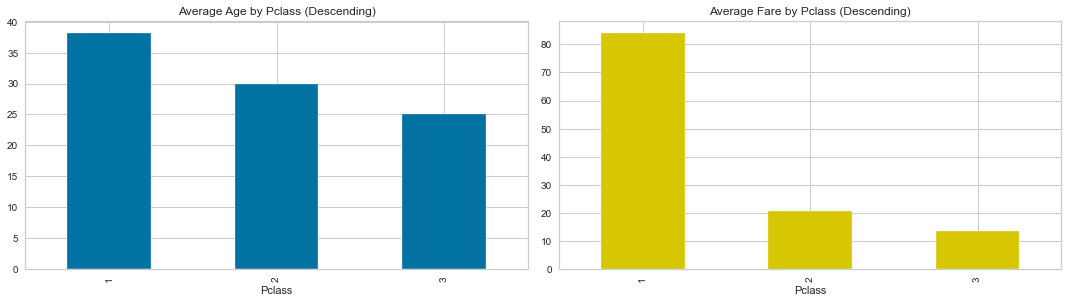

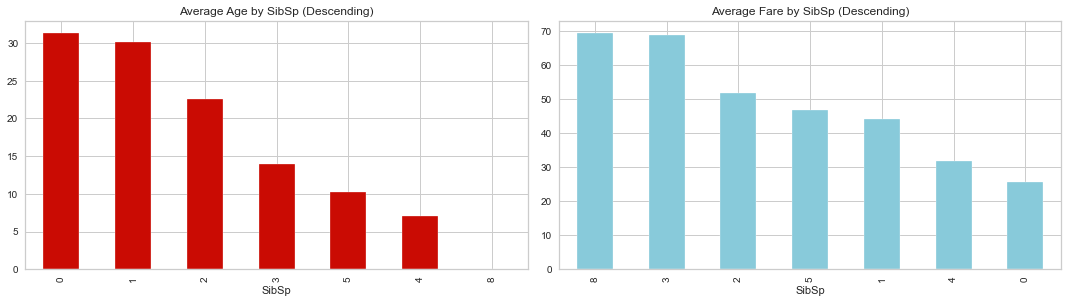

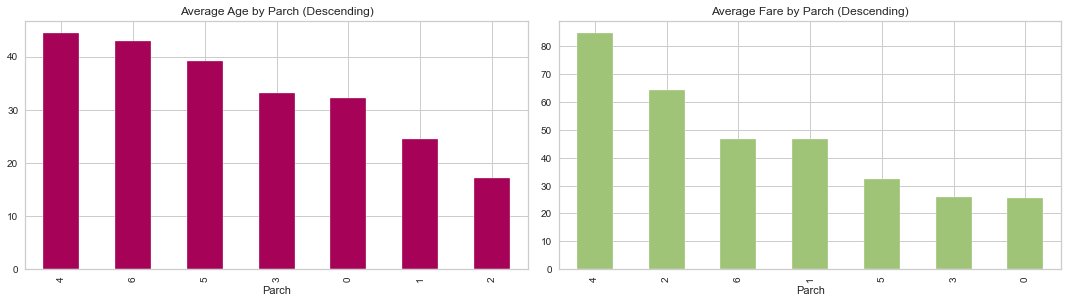

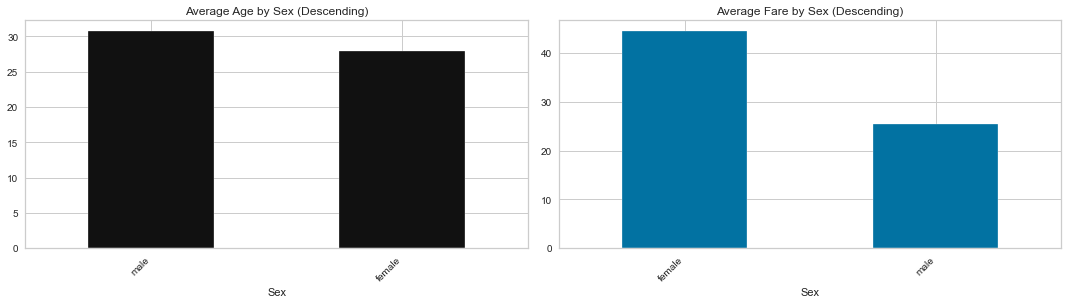

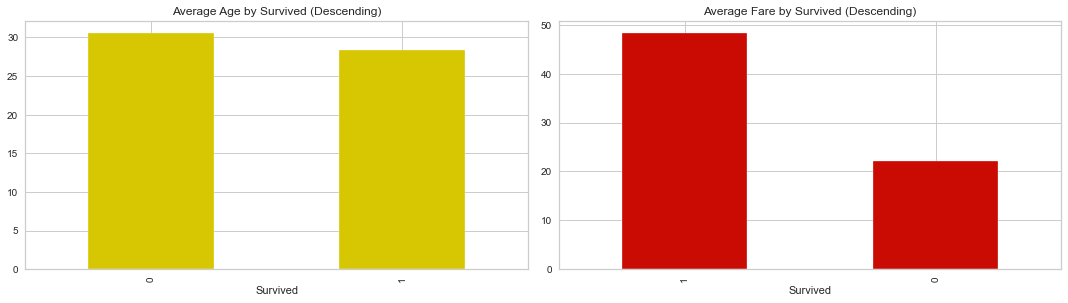

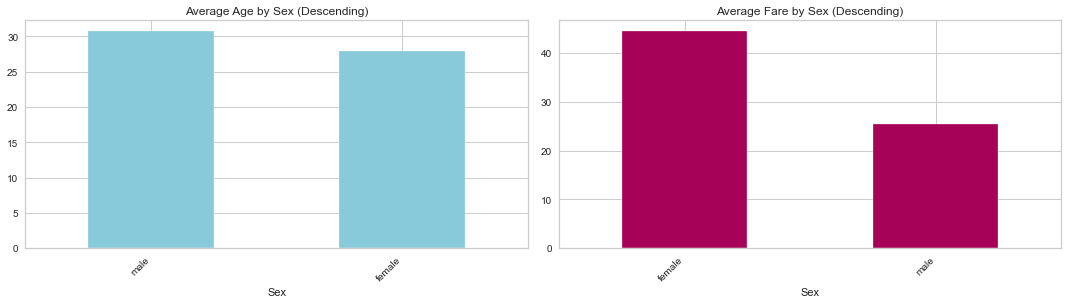

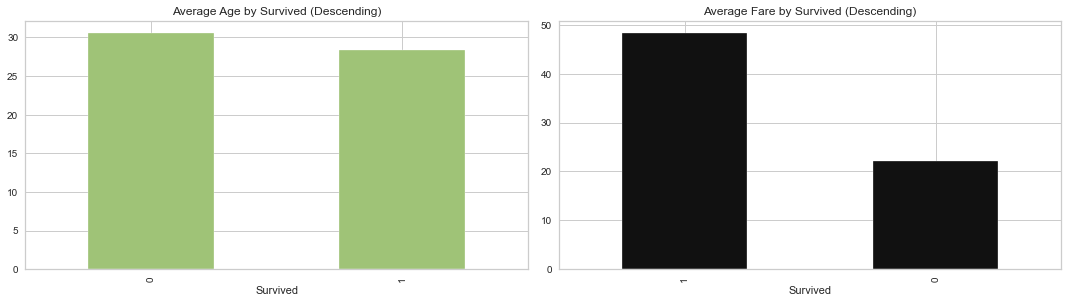

In [5]:
# More Visualization 
AV = AutoViz_Class()

# Let's now visualize the plots generated by AutoViz.
report_2 = AV.AutoViz("train.csv")

### Some Commets after exploring our data :


##### Caterogrocal Columns: Embarked, Capin, Sex, Name and Ticket
##### Ticket coloumn  has a high cardinality but not all distinct so there are more than one person with the same ticket and they may have any kind of a relationship helped in their survival..let's see
##### Fare column has a wide range from 0 to 512 with high variance 
##### From the corrolation Matrix , there is a negative corrolation between class and survival 
##### We can make a use of the capin col as I noticed for example that passnegers of  class 3 were in F,G and E capins
##### There is a strong corrolation between Class and Fare which makes sense
##### There are aloooot of missing values from age col but we can infer it from the title in the name col 
##### There are also many missing values in Fare col , we can fill it using the negative relationhip between Fare and Class 
##### 68% of survivors were females despite that 64% of passengers were males




### Feature Engineering
##### I. Encoding Categorical Columns 

In [6]:
# encode sex column into 0 for female and 1 for male 
sex_enc=preprocessing.LabelEncoder()
X_train["Sex_enc"]=sex_enc.fit_transform(X_train["Sex"])
X_valid["Sex_enc"]= sex_enc.transform(X_valid["Sex"])
test_data["Sex_enc"]=sex_enc.transform(test_data["Sex"])


#to avoid the model of creating a bais, standard scale Fare cus it has large scale 
Fare_std_scaler=StandardScaler()
X_train["std_Fare"]=Fare_std_scaler.fit_transform(np.array(X_train.Fare).reshape(-1,1))
X_valid["std_Fare"]=Fare_std_scaler.transform(np.array(X_valid.Fare).reshape(-1,1))
test_data["std_Fare"]=Fare_std_scaler.transform(np.array(test_data.Fare).reshape(-1,1))

# Generate a family col and we will see if it is uselful
X_train["Family"]=X_train["SibSp"]+X_train["Parch"]
X_valid["Family"]=X_valid["SibSp"]+X_valid["Parch"]
test_data["Family"]=test_data["SibSp"]+test_data["Parch"]

## encode_Family
Family_enc_tar=ce.TargetEncoder(X_train["Embarked"])
X_train["Family_enc_tar"]=Family_enc_tar.fit_transform(X_train["Family"],y_train)
X_valid["Family_enc_tar"]= Family_enc_tar.transform(X_valid["Family"])
test_data["Family_enc_tar"]=Family_enc_tar.transform(test_data["Family"])

# encode the ticket using targetencoding to see if the holders of the same ticket number have any relationship helped them to survive together

Ticket_enc =ce.TargetEncoder(X_train["Ticket"])
X_train["Ticket_enc"]=Ticket_enc.fit_transform(X_train["Ticket"],y_train)
X_valid["Ticket_enc"]=Ticket_enc.transform(X_valid["Ticket"])
test_data["Ticket_enc"]=Ticket_enc.transform(test_data["Ticket"])

# fill nan values with the most major category('S') then Encode Embarked col
X_train["Embarked"].fillna(value='S',inplace=True)
Embar_enc=preprocessing.LabelEncoder()
X_train["Embarked_enc"]=Embar_enc.fit_transform(X_train["Embarked"])
X_valid["Embarked_enc"]= Embar_enc.transform(X_valid["Embarked"])
test_data["Embarked_enc"]=Embar_enc.transform(test_data["Embarked"])

# try to encode Embarked col with Target encoder to see directly if there is a relationship btween where you embarkd and your survival 
Embar_enc_tar=ce.TargetEncoder(X_train["Embarked"])
X_train["Embarked_enc_tar"]=Embar_enc_tar.fit_transform(X_train["Embarked"],y_train)
X_valid["Embarked_enc_tar"]= Embar_enc_tar.transform(X_valid["Embarked"])
test_data["Embarked_enc_tar"]=Embar_enc_tar.transform(test_data["Embarked"])

# Extract Capin Letter and fill nan values based on class 
#X_train["Cabin_letter"]=X_train["Cabin"].str.extract(pat = '([A-Z])')
#print (X_train.groupby("Cabin_letter").Pclass.describe() )

# Create new title column to help us infer age and standardze the values
X_train["Title"]=X_train["Name"].str.split(',',expand=True)[1].str.split('.',expand=True)[0]
X_valid["Title"]=X_valid["Name"].str.split(',',expand=True)[1].str.split('.',expand=True)[0]
test_data["Title"]=test_data["Name"].str.split(',',expand=True)[1].str.split('.',expand=True)[0]

## Target encode the title column
Title_enc_tar=ce.TargetEncoder(X_train["Title"])
X_train["Title_enc_tar"]=Title_enc_tar.fit_transform(X_train["Title"],y_train)
X_valid["Title_enc_tar"]= Title_enc_tar.transform(X_valid["Title"])
test_data["Title_enc_tar"]=Title_enc_tar.transform(test_data["Title"])


## fill Nan values of Age
avg_age_per_title=X_train.groupby("Title").Age.mean()
intermediate_df_train=X_train[X_train.Age.isnull()]
intermediate_df_train.Age=avg_age_per_title[intermediate_df_train.Title].values.astype(int)
X_train.Age.fillna(intermediate_df_train.Age,inplace=True)

intermediate_df_valid=X_valid[X_valid.Age.isnull()]
intermediate_df_valid.Age=avg_age_per_title[intermediate_df_valid.Title].values.astype(int)
X_valid.Age.fillna(intermediate_df_valid.Age,inplace=True)

intermediate_df_test=test_data[test_data.Age.isnull()]
intermediate_df_test.Age=avg_age_per_title[intermediate_df_test.Title].values.astype(int)
test_data.Age.fillna(intermediate_df_test.Age,inplace=True)



Age_std_scaler=StandardScaler()
X_train["std_Age"]=Age_std_scaler.fit_transform(np.array(X_train.Age).reshape(-1,1))
X_valid["std_Age"]=Age_std_scaler.transform(np.array(X_valid.Age).reshape(-1,1))
test_data["std_Age"]=Age_std_scaler.transform(np.array(test_data.Age).reshape(-1,1))


## deopping unneeded cols.
X_train1=X_train.drop(columns=['Name','Cabin','Ticket','Sex','Age','Ticket','Fare','Embarked','Title','Family'])
X_valid1=X_valid.drop(columns=['Name','Cabin','Ticket','Sex','Age','Ticket','Fare','Embarked','Title','Family'])
test_data1=test_data.drop(columns=['Name','Cabin','Ticket','Sex','Age','Ticket','Fare','Embarked','Title','Family'])

##### II.Feature Selection  using L1 penality 

In [7]:
log_reg = LogisticRegression(penalty='l1',solver='liblinear',C=0.05).fit(X_train1, y_train)
selector = SelectFromModel(log_reg, prefit=True)
X_new = selector.transform(X_train1)
X_train_selected_features=pd.DataFrame(selector.inverse_transform(X_new),columns=X_train1.columns)
X_valid_selected_features=X_valid1.copy()
test_data_selected_features=test_data1.copy()
for i in X_train_selected_features.columns:
    if X_train_selected_features[i].mean()==0:
        X_train_selected_features.drop(columns=i,inplace=True)
        X_valid_selected_features.drop(columns=i,inplace=True)
        test_data_selected_features.drop(columns=i,inplace=True)
        
        
print("So here is the set of the selected Features ..... \n \n",X_train_selected_features.columns)

So here is the set of the selected Features ..... 
 
 Index(['PassengerId', 'Pclass', 'Sex_enc', 'Ticket_enc', 'Title_enc_tar',
       'std_Age'],
      dtype='object')


## Learning our models
##### First, I will start learning using one  or two features just to have get some insight

In [8]:
# helping Function
def to_np_arr(arr):
    return np.array(arr).reshape(-1,1)



In [9]:

model_gender=tree.DecisionTreeClassifier(max_depth=5)
model_gender.fit(to_np_arr(X_train_selected_features.Sex_enc),to_np_arr(y_train))
model_gender_score= model_gender.score(to_np_arr(X_train_selected_features.Sex_enc),to_np_arr(y_train))
valid_gender=model_gender.score(to_np_arr(X_valid_selected_features.Sex_enc),to_np_arr(y_valid))

model_age=tree.DecisionTreeClassifier(max_depth=5)
model_age.fit(to_np_arr(X_train_selected_features.std_Age),to_np_arr(y_train))
#tree.plot_tree(model_gender)
model_age_score= model_gender.score(to_np_arr(X_train_selected_features.std_Age),to_np_arr(y_train))
valid_age=model_gender.score(to_np_arr(X_valid_selected_features.std_Age),to_np_arr(y_valid))


model_class=tree.DecisionTreeClassifier(max_depth=5)
model_class.fit(to_np_arr(X_train_selected_features.Pclass),to_np_arr(y_train))
model_class_score= model_class.score(to_np_arr(X_train_selected_features.Pclass),to_np_arr(y_train))
valid_class=model_gender.score(to_np_arr(X_valid_selected_features.Pclass),to_np_arr(y_valid))

print("Training Accurcy for gender only model is \n \n Training Acc:",model_gender_score,"\n Valid Acc:",valid_class," \n \n Training Acc for Age only model is \n","\n Training Acc",model_age_score,"\n Valid Acc:",valid_age," \n \nTraining Acc for PClass only model is \n ","\n Training Acc",model_class_score,"\n valid acc :",valid_class)

Training Accurcy for gender only model is 
 
 Training Acc: 0.784019975031211 
 Valid Acc: 0.6  
 
 Training Acc for Age only model is 
 
 Training Acc 0.4369538077403246 
 Valid Acc: 0.4888888888888889  
 
Training Acc for PClass only model is 
  
 Training Acc 0.6754057428214731 
 valid acc : 0.6


##### Looks like as we predicted Passeneger Gender has a lot to do with their Survival!  
###### Lets see that more 

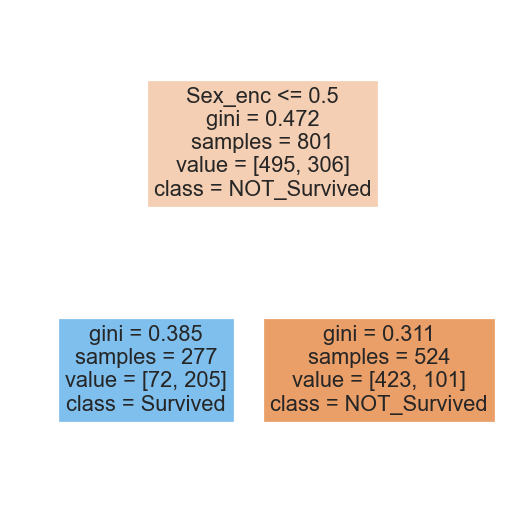

In [10]:
fn=['Sex_enc']  
cn=['NOT_Survived',"Survived"]  #sorted ascending numerically so notsurvived=0 first 
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (2,2), dpi=300)
tree.plot_tree(model_gender,
               feature_names = fn, 
               class_names=cn,
               filled = True);
fig.savefig('imagename.png')

#### knowing that Female is encoded withh 0 and male with 1 ,  The previous fig shows that the model predicts high survival for females 

#### Two-Feature model

In [11]:
gender_class=["Pclass","Sex_enc"]
model2=tree.DecisionTreeClassifier(max_depth=6)
model2.fit(X_train_selected_features[gender_class],to_np_arr(y_train))
model2_score= model2.score(X_train_selected_features[gender_class],to_np_arr(y_train))
valid_model2=model2.score(X_valid_selected_features[gender_class],to_np_arr(y_valid))

print("Training Acc for the two-Features model is ",model2_score,"\nValidation Acc: ",valid_model2 ,"\nOk..This is the best till now!!")


Training Acc for the two-Features model is  0.787765293383271 
Validation Acc:  0.7777777777777778 
Ok..This is the best till now!!


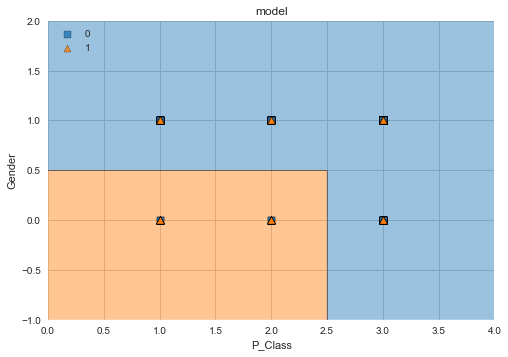

In [12]:
# This plot shows the  decision boundary for the social class and age  for tree of depth=10
X_=X_train_selected_features[gender_class].to_numpy()
plot_decision_regions(X_,to_np_arr(y_train).flatten(), clf=model2, legend=2)

# Adding axes annotations
plt.xlabel('P_Class')
plt.ylabel('Gender')
plt.title('model')
plt.show()

The above visualization of the decision boundary shows that survival favors female of class 1

# All Features Models
### I.DecisionTreeClassifier

In [13]:
parameters = {
    "max_depth": [3, 5, 7, 9, 11, 13],
}

model_desicion_tree = tree.DecisionTreeClassifier(
    random_state=1,
    class_weight='balanced',
)

model_desicion_tree = GridSearchCV(
    model_desicion_tree, 
    parameters, 
    cv=30,
    scoring='accuracy',
)
model_desicion_tree.fit(X_train_selected_features,to_np_arr(y_train))
print("chosen param is ",model_desicion_tree.best_params_,"Training Acc when applying chosen params",model_desicion_tree.best_score_)
print("Validation acc : ", model_desicion_tree.score(X_valid_selected_features,to_np_arr(y_valid)))

chosen param is  {'max_depth': 3} Training Acc when applying chosen params 0.8753561253561253
Validation acc :  0.8222222222222222


# Aloooot Better whoooohooo 

### II.RandomForestClassifier

In [14]:
parameters = {
    "n_estimators": [5, 10, 15, 20, 25], 
    "max_depth": [3, 5, 7, 9, 11, 13],
}
rf_model=GridSearchCV(RandomForestClassifier( random_state=0),parameters,cv=30,scoring='accuracy')
rf_model.fit(X_train_selected_features,to_np_arr(y_train))
print("chosen params are ",rf_model.best_params_,"Training Acc when applying chosen params",rf_model.best_score_)
print("Validation acc : ", rf_model.score(X_valid_selected_features,to_np_arr(y_valid)))

chosen params are  {'max_depth': 9, 'n_estimators': 20} Training Acc when applying chosen params 0.8716999050332384
Validation acc :  0.8666666666666667


#### Better *Dancing and praying it will do the same on the test set

### III.NN

In [15]:
model_NN = models.Sequential()
model_NN.add(Dense(60, activation='relu'))
model_NN.add(Dense(40, activation='relu'))
model_NN.add(Dense(20, activation='relu'))
model_NN.add(Dense(10, activation='relu'))
model_NN.add(Dense(1, activation='sigmoid'))
model_NN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history=model_NN.fit(X_train_selected_features,to_np_arr(y_train),epochs=150, batch_size=10) 

Epoch 1/150

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

81/81 [==============================] - 0s 1ms/step - loss: 2.8195 - accuracy: 0.5680
Epoch 2/150
81/81 [==============================] - 0s 2ms/step - loss: 0.8775 - accuracy: 0.5181
Epoch 3/150
81/81 [==============================] - 0s 1ms/step - loss: 0.8994 - accuracy: 0.5568
Epoch 4/150
81/81 [==============================] - 0s 2ms/step - loss: 0.8264 - accuracy: 0.5793
Epoch 5/150
81/81 [==============================] - 0s 1ms/step - loss: 0.7966 - accuracy: 0.5880
Epoch 6/150
8

81/81 [==============================] - 0s 2ms/step - loss: 0.4267 - accuracy: 0.8302
Epoch 76/150
81/81 [==============================] - 0s 2ms/step - loss: 0.3975 - accuracy: 0.8427
Epoch 77/150
81/81 [==============================] - 0s 1ms/step - loss: 0.4035 - accuracy: 0.8477
Epoch 78/150
81/81 [==============================] - 0s 1ms/step - loss: 0.4007 - accuracy: 0.8402
Epoch 79/150
81/81 [==============================] - 0s 1ms/step - loss: 0.3877 - accuracy: 0.8514
Epoch 80/150
81/81 [==============================] - 0s 2ms/step - loss: 0.3972 - accuracy: 0.8402
Epoch 81/150
81/81 [==============================] - 0s 1ms/step - loss: 0.4002 - accuracy: 0.8477
Epoch 82/150
81/81 [==============================] - 0s 2ms/step - loss: 0.4270 - accuracy: 0.8227
Epoch 83/150
81/81 [==============================] - 0s 2ms/step - loss: 0.4281 - accuracy: 0.8377
Epoch 84/150
81/81 [==============================] - 0s 2ms/step - loss: 0.3994 - accuracy: 0.8452
Epoch 85/150


3/3 [==============================] - 0s 2ms/step - loss: 0.3900 - accuracy: 0.8333
Accuracy on Validation Set: 83.33


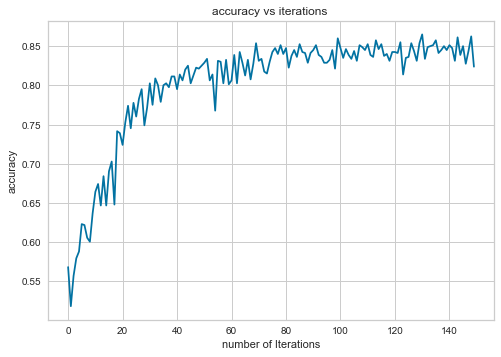

In [16]:
plt.plot(history.history["accuracy"])
plt.xlabel("number of Iterations")
plt.ylabel("accuracy")
plt.title("accuracy vs iterations ")


# evaluate the keras model
_, accuracy = model_NN.evaluate(X_valid_selected_features,to_np_arr(y_valid))
print('Accuracy on Validation Set: %.2f' % (accuracy*100))

### IV. Logistic Regression

In [17]:
preprocessor=preprocessing.PolynomialFeatures(degree=1)
fs_poly_train=preprocessor.fit_transform(X_train_selected_features)
fs_poly_valid=preprocessor.transform(X_valid_selected_features)

log_model = LogisticRegression(random_state=0 ,penalty='l2',C=0.1).fit(fs_poly_train, to_np_arr(y_train))
print("Training acc of logistic regression model with first degree ",log_model.score(fs_poly_train,to_np_arr(y_train)))
print("\nValidation Acc:",log_model.score(fs_poly_valid, to_np_arr(y_valid)))

Training acc of logistic regression model with first degree  0.8601747815230961

Validation Acc: 0.8555555555555555


### Let's finish with 
##### V. Support Support Vector Classification 

In [18]:
parameters={
    "C":[0.1 ,1, 10 ],
    "degree":[1 ,2 ,3 ],
       
    
}

#model_SVC_pred=GridSearchCV(SVC(kernel='linear'),parameters,cv=5,scoring='accuracy')
model_SVC_pred=SVC(C= 1, degree= 3, gamma=1, kernel= 'linear')
model_SVC_pred.fit(X_train_selected_features,to_np_arr(y_train))
model_SVC_pred_score=model_SVC_pred.score(X_train_selected_features,to_np_arr(y_train))

In [19]:
valid_acc_svc=model_SVC_pred.score(X_valid_selected_features,to_np_arr(y_valid))
#print("chosen params are ",model_SVC_pred.best_params_,"Training Acc when applying chosen params",model_SVC_pred.best_score_)
print("Training Acc:",model_SVC_pred_score,"\n Validation Acc:" ,valid_acc_svc)


Training Acc: 0.8639200998751561 
 Validation Acc: 0.8333333333333334


### Ensembling Classifiers(learn a weighted average of each one of them , get them working together, get higher Acc , Hopfully)


In [20]:
tree_pred_train = model_desicion_tree.predict(X_train_selected_features)
rf_train_pred = rf_model.predict(X_train_selected_features)
nn_pred_train = model_NN.predict_classes(X_train_selected_features)
log_train_pred = log_model.predict(preprocessor.transform(X_train_selected_features))
svc_train_pred=model_SVC_pred.predict(X_train_selected_features)

all_models_train=pd.DataFrame({"tree_pred_train":tree_pred_train,"rf_train_pred":rf_train_pred,"nn_pred_train":nn_pred_train.flatten(),"log_train_pred":log_train_pred,'svc':svc_train_pred},index=X_train_selected_features.index)


tree_pred_valid = model_desicion_tree.predict(X_valid_selected_features)
rf_valid_pred = rf_model.predict(X_valid_selected_features)
nn_pred_valid = model_NN.predict_classes(X_valid_selected_features)
log_valid_pred = log_model.predict(preprocessor.transform(X_valid_selected_features))
svc_valid_pred=model_SVC_pred.predict(X_valid_selected_features)

all_models_valid=pd.DataFrame({"tree_pred_valid":tree_pred_valid,"rf_valid_pred":rf_valid_pred,"nn_pred_valid":nn_pred_valid.flatten(),"log_valid_pred":log_valid_pred,'svc':svc_valid_pred})
#all_models_pred.join(pd.Series({'nn_pred_train':nn_pred_train})[0])
#mean_train_pred = np.round((rf_train_pred + SVC_train_pred + tree_pred_train + log_train_pred ) / 4)
## Creating a data frame of the prev predictions 


parameters={"degree":[1,2,3,4,5],"gamma":[1, 0.1, 0.001, 0.0001, 'auto'],"kernel":['linear', 'poly', 'rbf']}

#Ensamling_pred=GridSearchCV(SVC(C=0.01),parameters,cv=5,scoring='accuracy')
Ensamling_pred=SVC(C= 0.01,kernel='linear',gamma=1)
Ensamling_pred.fit(all_models_train, to_np_arr(y_train))
Ensamling_pred_score=Ensamling_pred.score(all_models_train,to_np_arr(y_train))
#print("chosen params are ",Ensamling_pred.best_params_,"Training Acc when applying chosen params",Ensamling_pred.best_score_)
valid_score_Ensambling=Ensamling_pred.score(all_models_valid,to_np_arr(y_valid))
print("\n Training Score",Ensamling_pred_score,"\nValidation Acc:",valid_score_Ensambling)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).

 Training Score 0.8926342072409488 
Validation Acc: 0.8666666666666667


In [21]:
# Let's look at the coeff of the last model 

weighted_avg=Ensamling_pred.coef_
print("coeff of Decision Tree Model",weighted_avg[0][0])
print("coeff of Random Forest Model",weighted_avg[0][1])
print("coeff of NN  Model",weighted_avg[0][2])
print("coeff of Logestic Regression Model",weighted_avg[0][3])
print("coeff of SVC Model",weighted_avg[0][4])



coeff of Decision Tree Model 0.4439999999999998
coeff of Random Forest Model 0.8340000000000002
coeff of NN  Model 0.06399999999999982
coeff of Logestic Regression Model 0.3139999999999998
coeff of SVC Model 0.34400000000000003


#### From the previous coeffs, the biggest contribution belongs to  Random Forest

In [22]:
tree_pred_test= model_desicion_tree.predict(test_data_selected_features)
rf_test_pred = rf_model.predict(test_data_selected_features)
nn_pred_test = model_NN.predict_classes(test_data_selected_features)
log_test_pred = log_model.predict(preprocessor.transform(test_data_selected_features))
svc_test_pred=model_SVC_pred.predict(test_data_selected_features)

all_models_test=pd.DataFrame({"tree_pred_valid":tree_pred_test,"rf_valid_pred":rf_test_pred,"nn_pred_valid":nn_pred_test.flatten(),"log_valid_pred":log_test_pred,'svc':svc_test_pred})
ypred_test=Ensamling_pred.predict(all_models_test)
sub_file=pd.DataFrame({"PassengerId":test_data.PassengerId,"Survived":ypred_test},dtype=np.int64)

sub_file.to_csv("sub_file.csv",index=False)

### Achieved 0.78225 on Test Data 